In [7]:
import numpy as np
import scipy.interpolate as interpolate
import re
import glob

In [8]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [166]:
def ChristodoulouMass(run, ahn, ihn):
    mIrr = ReadAHMass(run, ahn)
    Svec = ReadIsolatedHorizonSpin(run,ihn)
    S = np.empty(shape=(2, Svec.shape[1]), dtype=Svec.dtype)
    S[0,:] = Svec[0,:]
    S[1,:] = np.sqrt(Svec[1,:]**2+Svec[2,:]**2+Svec[3,:]**2)

    (mIrr, S) = ResampleToSmallestTimestep([mIrr, S])
    
    mChristodoulou = np.empty(shape=(2, S.shape[1]), dtype=S.dtype)
    mChristodoulou[0,:] = S[0, :]
    mChristodoulou[1,:] = np.sqrt(mIrr[1:,:]**2 + S[1:,:]**2/(4*mIrr[1:,:]**2))
    
    return mChristodoulou

In [167]:
def ReadAHMass(runName, hn):
    return ReadColumnFile(runName, "BH_diagnostics.ah%d.gp" % hn, [1, 26])

In [168]:
def ReadIsolatedHorizonSpin(runName, hn):
    # TODO: make ReadColumFile accept a pattern
    # FIXME: need to pass a list of columns to read to ReadColumnFile
    return ReadColumnFile(runName, "quasilocalmeasures-qlm_scalars..asc",
                          ["time", "qlm_coordspinx[%d]" % hn, "qlm_coordspiny[%d]" % hn,
                           "qlm_coordspinz[%d]" % hn])

In [169]:
def joinDsets(dsets):
    """joints multiple datasets which each have a
    time like first column, eg iteration number of
    time. Removes overlapping segments, keeping the
    last segment.
    
    dsets = iterable of 2d array like objects with data"""
    # joins multiple datasets of which the first column is assumed to be "time"
    if(not dsets):
        return None
    length = 0
    for d in dsets:
        length += len(d)
    newshape = list(dsets[0].shape)
    newshape[0] = length
    dset = np.empty(shape=newshape, dtype=dsets[0].dtype)
    usedlength = 0
    for d in dsets:
        insertpointidx = np.where(dset[0:usedlength,0] >= d[0,0])
        if(insertpointidx[0].size):
            insertpoint = insertpointidx[0][0]
        else:
            insertpoint = usedlength
        newlength = insertpoint+len(d)
        dset[insertpoint:newlength] = d
        usedlength = newlength
    return dset[0:usedlength]


def loadASCIISeries(nameglob):
    """loads a set of ASCII output files, concatenating their data
    using the time or iteration columns
    
    nameglob = a shell glob that matches all files to be loaded,
    files are sorted alphabetically"""
    dsets = list()
    for fn in sorted(glob.glob(nameglob)):
        dsets.append(np.loadtxt(fn))
    return joinDsets(dsets).transpose()

In [170]:
def ParseASCIIHeader(filename):
    columns = {}
    with open(filename, "r") as fh:
        for line in fh:
            line = line.rstrip("\n")
            mComment = re.match(r"^#\s*", line)
            mBlank = re.match(r"^\s*$", line)
            if(mComment):
                m = re.match(r"^#\s*([^:]*):", line)
                if(m and (m.group(1) == "column format" or m.group(1) == "data columns")):
                    fields = line.split()[3:]
                    for field in fields:
                        (colnum, colname) = field.split(":")
                        columns[colname] = int(colnum) - 1
                m = re.match(r"^#\s*column\s+([0-9]+)\s*=\s*(.*)", line)
                if(m):
                    (colnum, colname) = (m.group(1), m.group(2))
                    columns[colname] = int(colnum) - 1
            if(not mComment and not mBlank):
                break
    if not columns: ValueError("Could not parse header in %s" % filename)
    return columns

In [171]:
def ReadColumnFile(runName, fileName, columns=None):
    """Read a ASCII file with columns, accept a list of columns to read
    as either column numbers counting from 0 or column names which we try
    and parse out of the header"""
    fileGlob = "%s/output-????/%s/%s" % (runName, runName, fileName)
    
    firstFile = glob.glob(fileGlob)[0]
    dataColumns = ParseASCIIHeader(firstFile)
    
    data = loadASCIISeries(fileGlob)
    
    if columns is None:
        return data
    else:
        # check if columns are integers or strings
        try:
            int(columns[0])
            is_String = False
        except ValueError:
            is_String = True
        if(is_String):
            cols = [dataColumns[i] for i in columns]
        else:
            cols = columns
        return data[cols,:]
    ValueError("Internal Error")

In [192]:
def InterpolateToTime(data, time):
    f = interpolate.interp1d(data[0,:], data[1:,:], bounds_error=True, assume_sorted=True)
    return f([time])

In [193]:
def ResampleToSmallestTimestep(data):
    # first fine smallest timesteps in a all arrays passed
    # get common time bracket in all arrays
    dtmin = np.inf
    tmin = -np.inf
    tmax = +np.inf
    for d in data:
        # TODO: check that spacing is uniform
        dt = d[0,1] - d[0,0]
        if(dt < dtmin):
            dtmin = dt
        if(d[0,0] > tmin):
            tmin = d[0,0]
        if(d[0,-1] < tmax):
            tmax = d[0,-1]
    times = np.arange(tmin, tmax, dtmin)
    
    retval = []
    for d in data:
        d_interp = interpolate.interp1d(d[0,:], d[1:,:], bounds_error=True, assume_sorted=True)
        vals = np.empty(shape=(d.shape[0],len(times)),dtype=d.dtype)
        vals[0,:] = times
        vals[1:,:] = d_interp(times)
        retval.append(vals)
    
    return retval

In [194]:
mass1 = ChristodoulouMass("E0001_N40", ahn=1, ihn=0)
mass2 = ChristodoulouMass("E0001_N40", ahn=2, ihn=1)
mass3 = ChristodoulouMass("E0001_N40", ahn=3, ihn=2)

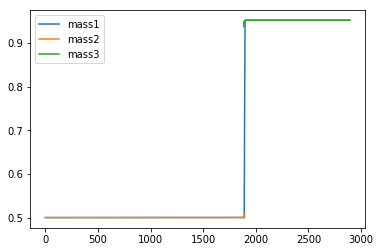

In [195]:
plt.plot(mass1[0,:], mass1[1,:], label="mass1")
plt.plot(mass2[0,:], mass2[1,:], label="mass2")
plt.plot(mass3[0,:], mass3[1,:], label="mass3")
plt.legend();

In [196]:
tRelaxed = 200.

In [197]:
relaxed_mass1 = InterpolateToTime(mass1, tRelaxed)
relaxed_mass2 = InterpolateToTime(mass2, tRelaxed)
print("massed at tRelaxed: %g, %g" % (relaxed_mass1, relaxed_mass2))
final_mass = mass3[1,-1]
print("Final mass: %g" % final_mass)

massed at tRelaxed: 0.499998, 0.499998
Final mass: 0.951804
